In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import time 
# from tensorflow.keras.applications import *
# from matplotlib import plotly as plt
import matplotlib.pyplot as plt
import numpy as np

In [4]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = x_train[0].shape


x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test)

x_test = tf.expand_dims(x_test, -1)
x_train = tf.expand_dims(x_train, -1)
print(x_test.shape)


2022-06-26 20:46:45.645140: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-26 20:46:45.645189: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hennessy
2022-06-26 20:46:45.645199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hennessy
2022-06-26 20:46:45.645279: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-26 20:46:45.645313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-26 20:46:45.645321: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-06-26 20:46:45.646491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

(10000, 28, 28, 1)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

input_shape = x_test[0].shape
num_classes = 10
print(input_shape)

(28, 28, 1)


In [6]:
"""
Runtime estimate: 

Input: 1000 components

Conv1: 9 * 32 * 28 * 28 = 200,000 multiplications + 200,000 additionss
MaxPool1: ~5,000 pixels * 4 comparisons / pixel = 20,000 comparisons 
Conv2: ~10,000 pixels * 10 mult / pixel = 100,000 multiplications + 100,000 adds
MaxPool2: ~1000 pixels * 4 comparisons / pixel = 4,000 comparisons 

Flatten/Dropout: ~0
Dense: 16,000 multiplications

= ~6*10^5 operations total for a forward pass (on a single image)

-> 10^7 per batch of 32 
-> a cpu can do 10^9 ops / sec 
-> batches run in .01 sec / batch 

Backprop: 
Compute gradients ~300,000 ops 
Save gradients: saving 300,000 vars 
Apply + scale gradients: ~600,000 ops 

= ~10^6 ops 

-> batches run in .1 sec / batch 


#A CPU does approx 10**9 ops / second

"""

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


optimizer=tf.keras.optimizers.Adam(0.001)
loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

# model.fit(
#     train_dataset,
#     epochs=6,
#     validation_data=test_dataset,
# )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  (None, 14, 14, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                                 
 dense (Dense)               (None, 128)               25216     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                        

In [7]:

forward_pass_times = []
backward_pass_times = []

epochs = 5
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            start = time.time()
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            end = time.time()
            forward_pass_times.append(end - start)
            
            # Compute the loss value for this minibatch.
            print(y_batch_train.shape)
            print(logits.shape)
            loss_value = loss_fn(y_batch_train, logits)

        start = time.time()
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        backward_pass_times.append(time.time() - start)
        
        if step > 100: 
            break

    print(f'forward pass 1-batch time = {np.array(forward_pass_times).mean()}')
    print(f'backwards pass 1-batch time = {np.array(backward_pass_times).mean()}')

    print(f"Training loss (for one epoch): {float(loss_value)})")


Start of epoch 0
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(32, 10)
(32,)
(

forward pass 1-batch time = 0.0064727067947387695
backwards pass 1-batch time = 0.010887693891338274
Training loss (for one epoch): 0.12508782744407654)


y_true=1
(1, 10, 196, 128)
(1, 10, 128, 128)
(1, 10, 128, 128)
(1, 10, 128, 128)
(1, 10, 128, 10)


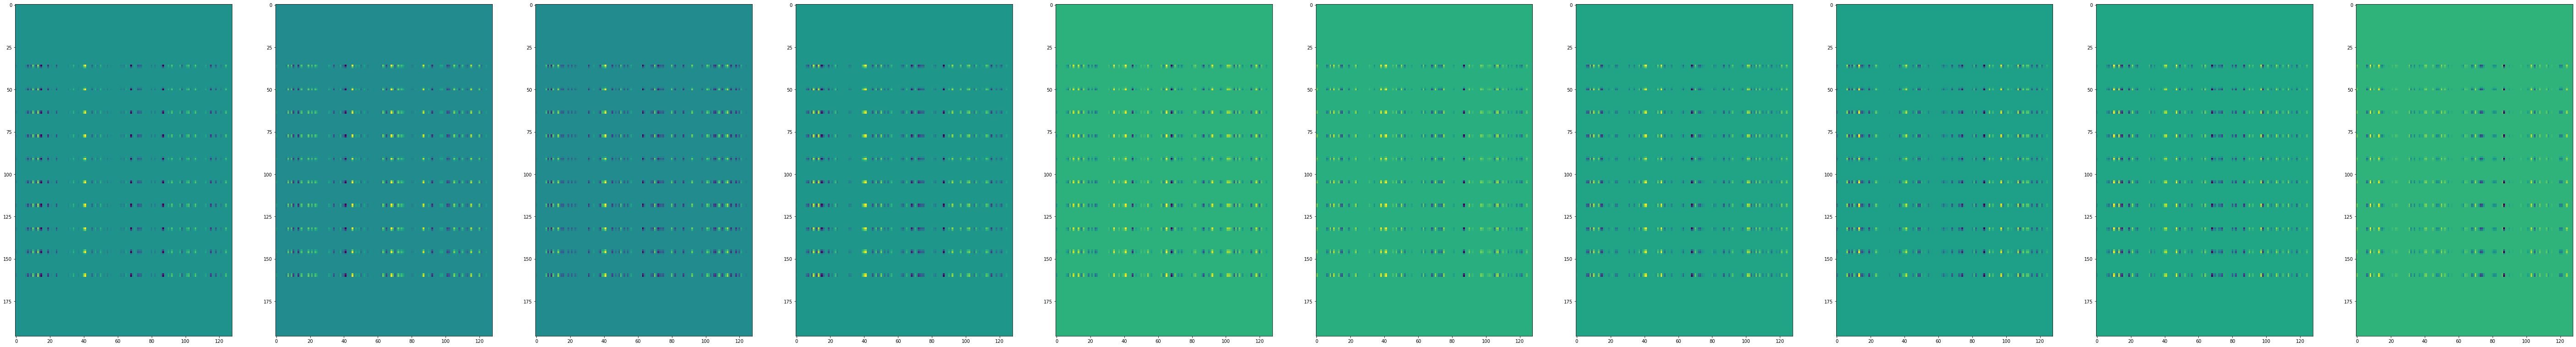

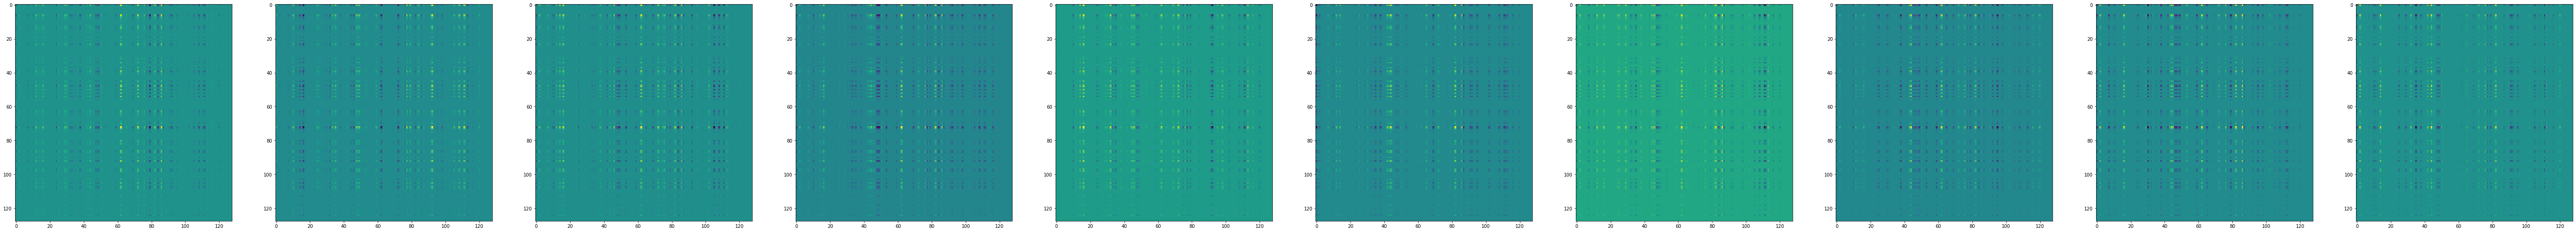

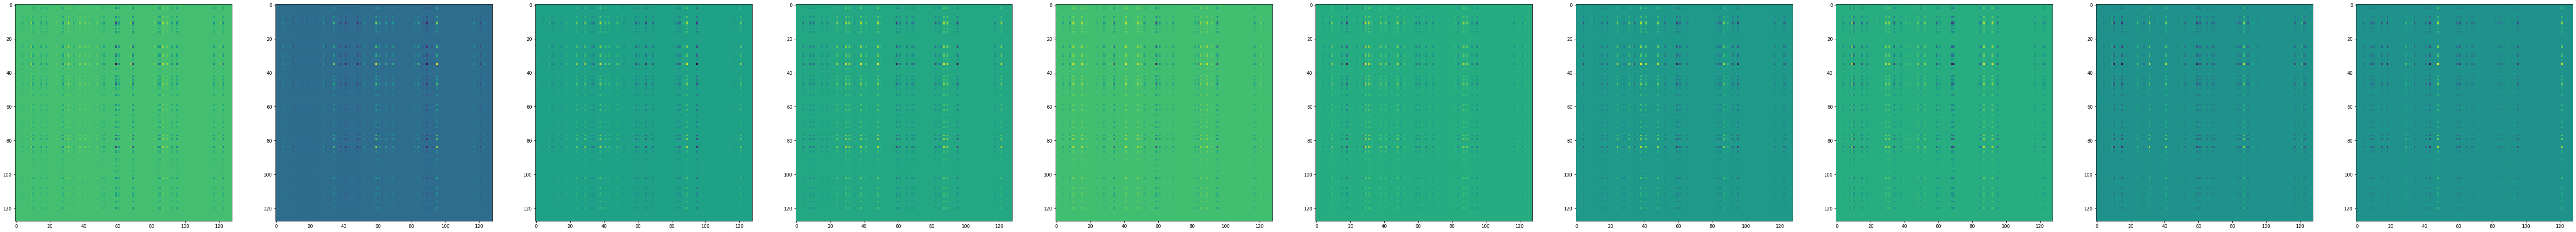

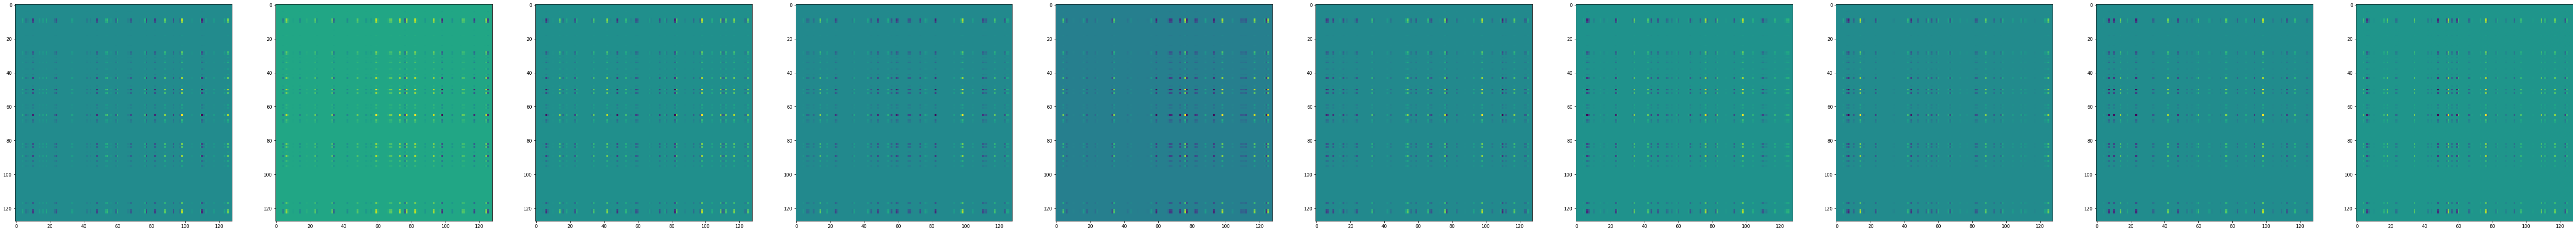

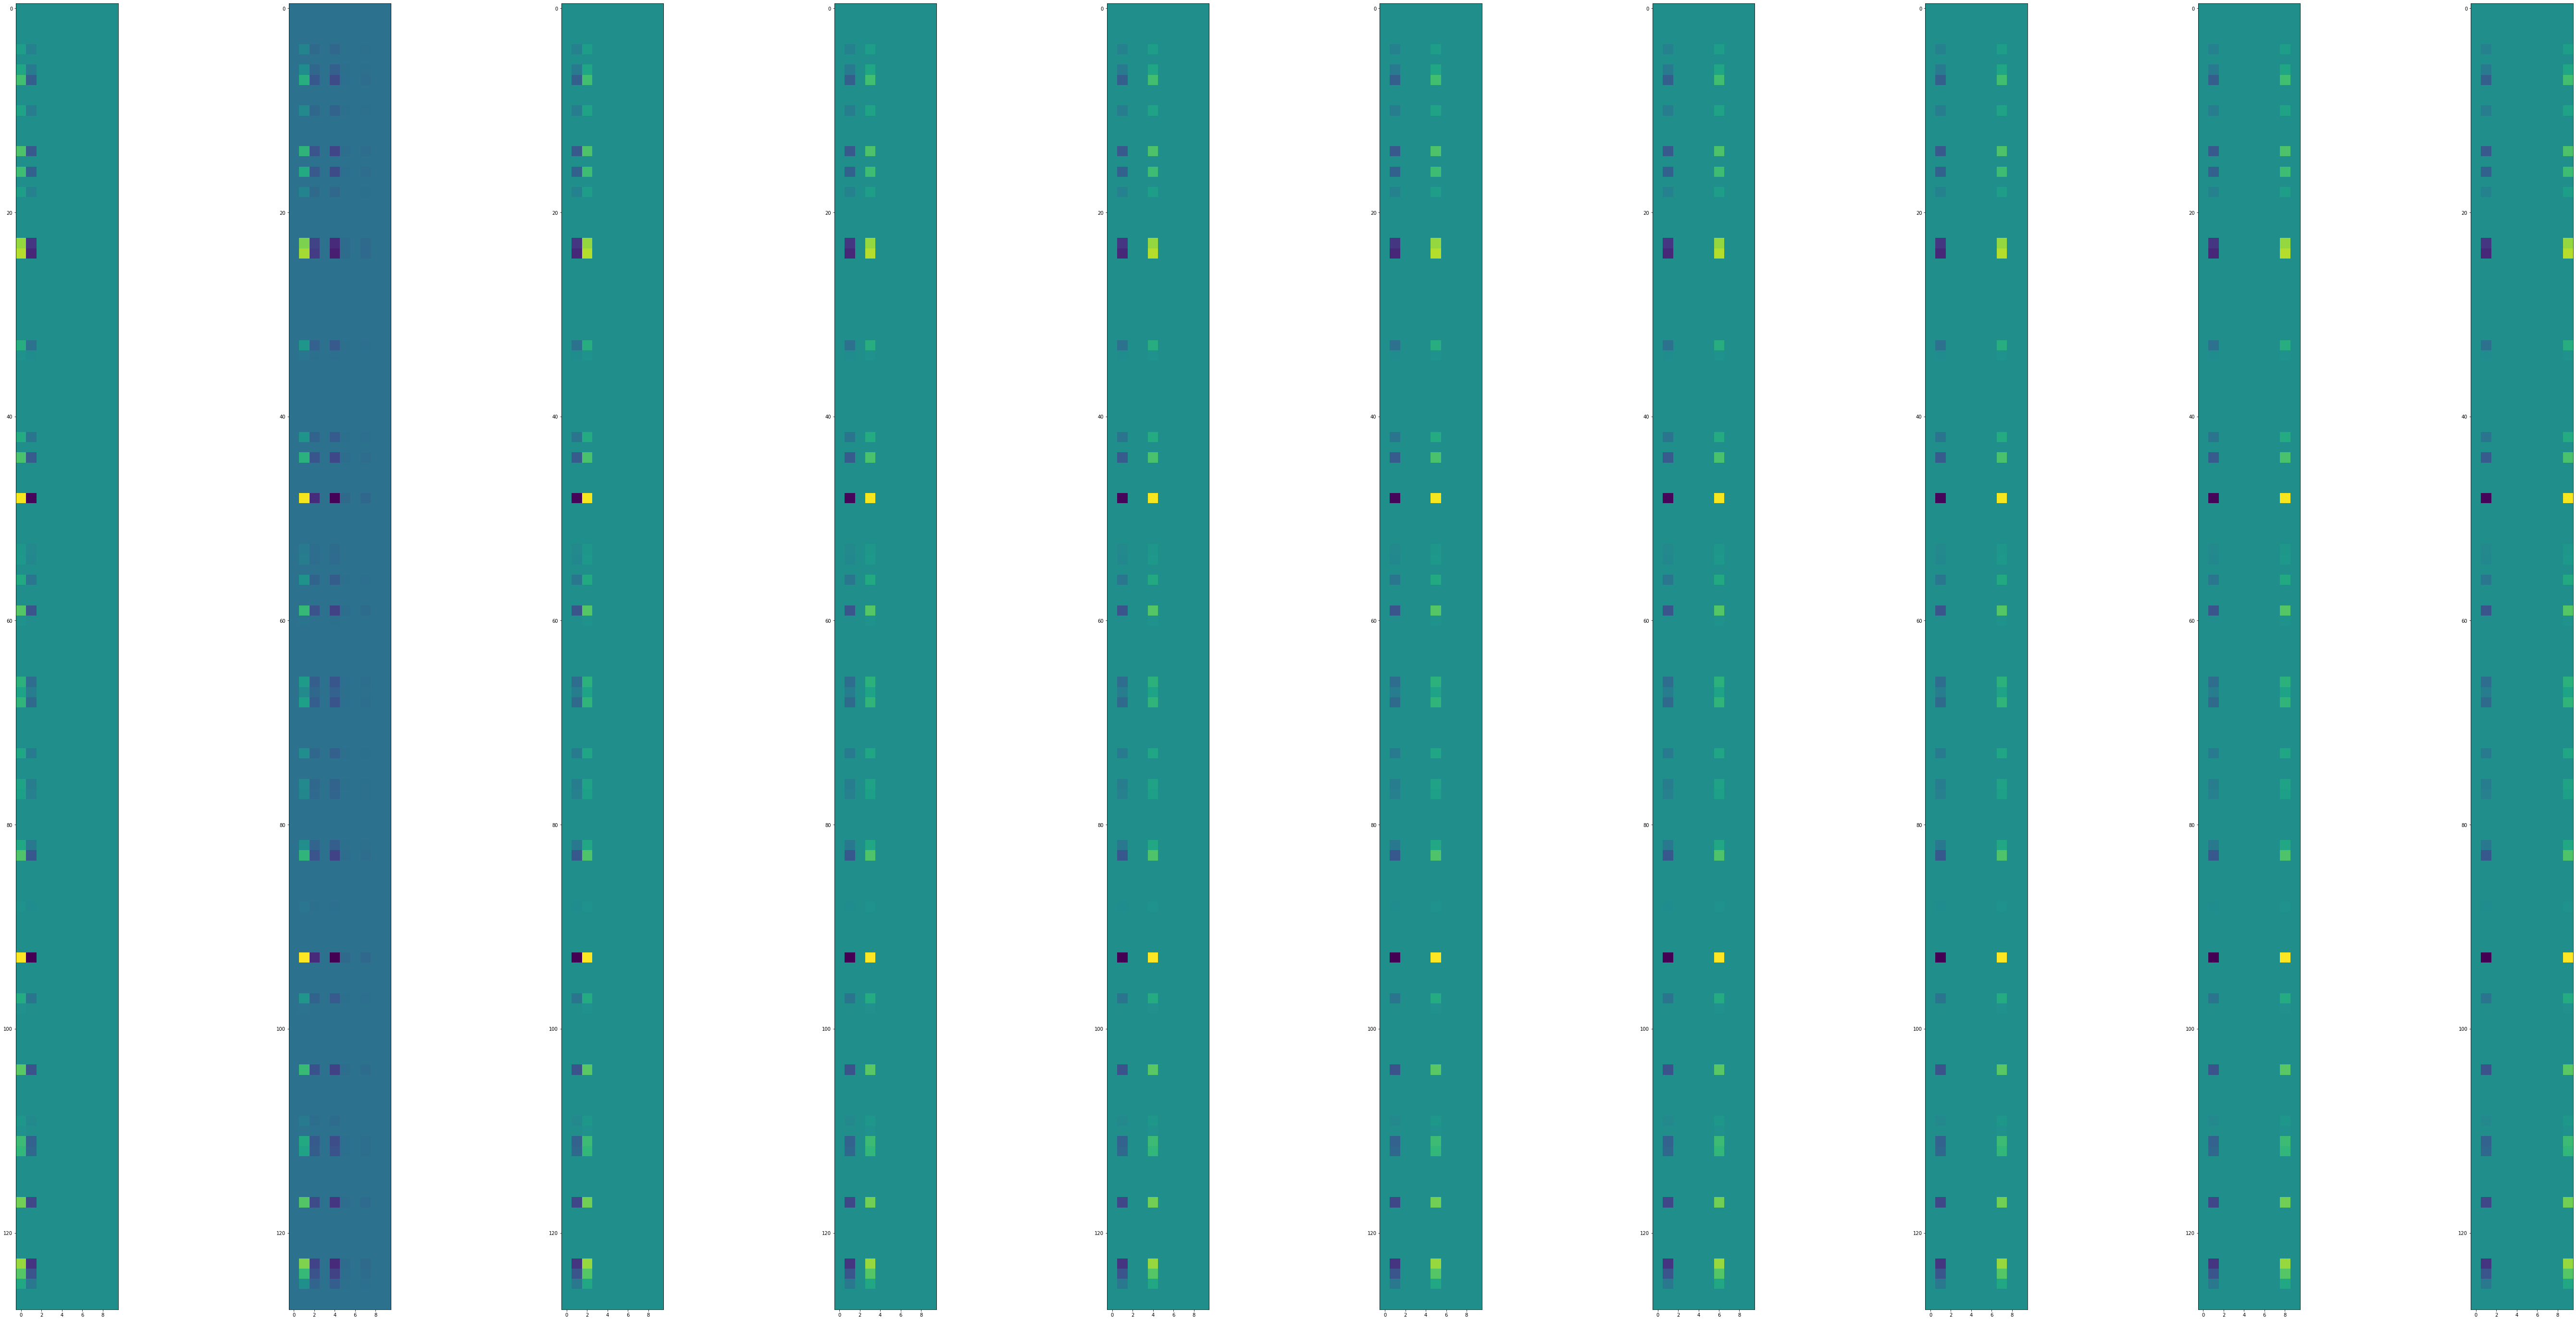

In [43]:
#Takes the jacobian of f with respect to j, evaluated at image. 
image = 2

x = tf.Variable(x_test[image:image+1])
#     plt.imshow(x[0])
y_true = y_test[image]    
print(f'y_true={y_true}')
y_hat = tf.Variable(tf.zeros(10))


    
def jacobian_f(f, fname): 
    with tf.GradientTape() as t:
        y_hat = model(x) 
    jac = t.jacobian(y_hat, f)
#     print(jac)
    if jac != None: 
        print(jac.shape)
    
    fig, ax = plt.subplots(1, 10, figsize=(100,50))

    for i in range(10):
        ax[i].imshow(jac[0, i])

#     plt.save_fig(f'jacobian_{gname}_{fname}_{i}')


for f, fname in [(model.trainable_variables[0], 'fc1'), 
             (model.trainable_variables[2], 'fc2'), 
             (model.trainable_variables[4], 'fc3'),
            (model.trainable_variables[6], 'fc4'),
            (model.trainable_variables[8], 'fc5')
                ]: 

    jacobian_f(f, fname)


In [ ]:
#Takes the jacobian of layer with respect to j, evaluated at image. 
image = 2

x = tf.Variable(x_test[image:image+1])
#     plt.imshow(x[0])
y_true = y_test[image]    
print(f'y_true={y_true}')
y_hat = tf.Variable(tf.zeros(10))


    
def jacobian_f(f, fname): 
    with tf.GradientTape() as t:
        y_hat = model(x) 
    jac = t.jacobian(y_hat, f)
#     print(jac)
    if jac != None: 
        print(jac.shape)
    
    fig, ax = plt.subplots(1, 10, figsize=(100,50))

    for i in range(10):
        ax[i].imshow(jac[0, i])

#     plt.save_fig(f'jacobian_{gname}_{fname}_{i}')


for f, fname in [(model.trainable_variables[0], 'fc1'), 
             (model.trainable_variables[2], 'fc2'), 
             (model.trainable_variables[4], 'fc3'),
            (model.trainable_variables[6], 'fc4'),
            (model.trainable_variables[8], 'fc5')
                ]: 

    jacobian_f(f, fname)


(1, 10, 196, 128)
tf.Tensor(
[2.0255607e-08 1.9476000e-14 1.9317252e-14 1.9317252e-14 1.9317252e-14
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(10,), dtype=float32)
tf.Tensor(
[1.4621978e-04 1.3944605e-10 1.3944605e-10 1.3944605e-10 1.3944605e-10
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(10,), dtype=float32)
tf.Tensor(
[6.7761066e-05 6.4621988e-11 6.4621988e-11 6.4621988e-11 6.4621988e-11
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(10,), dtype=float32)
tf.Tensor(
[3.5406224e-08 3.3766006e-14 3.3766006e-14 3.3766006e-14 3.3766006e-14
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(10,), dtype=float32)
tf.Tensor(
[1.0248000e-04 9.8579908e-11 9.7732544e-11 9.7732544e-11 9.7732544e-11
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(10,), dtype=float32)
tf.Tensor(
[9.348032e-06 9.538077e-12 8.914978e-12 8.914978e-12 8.9

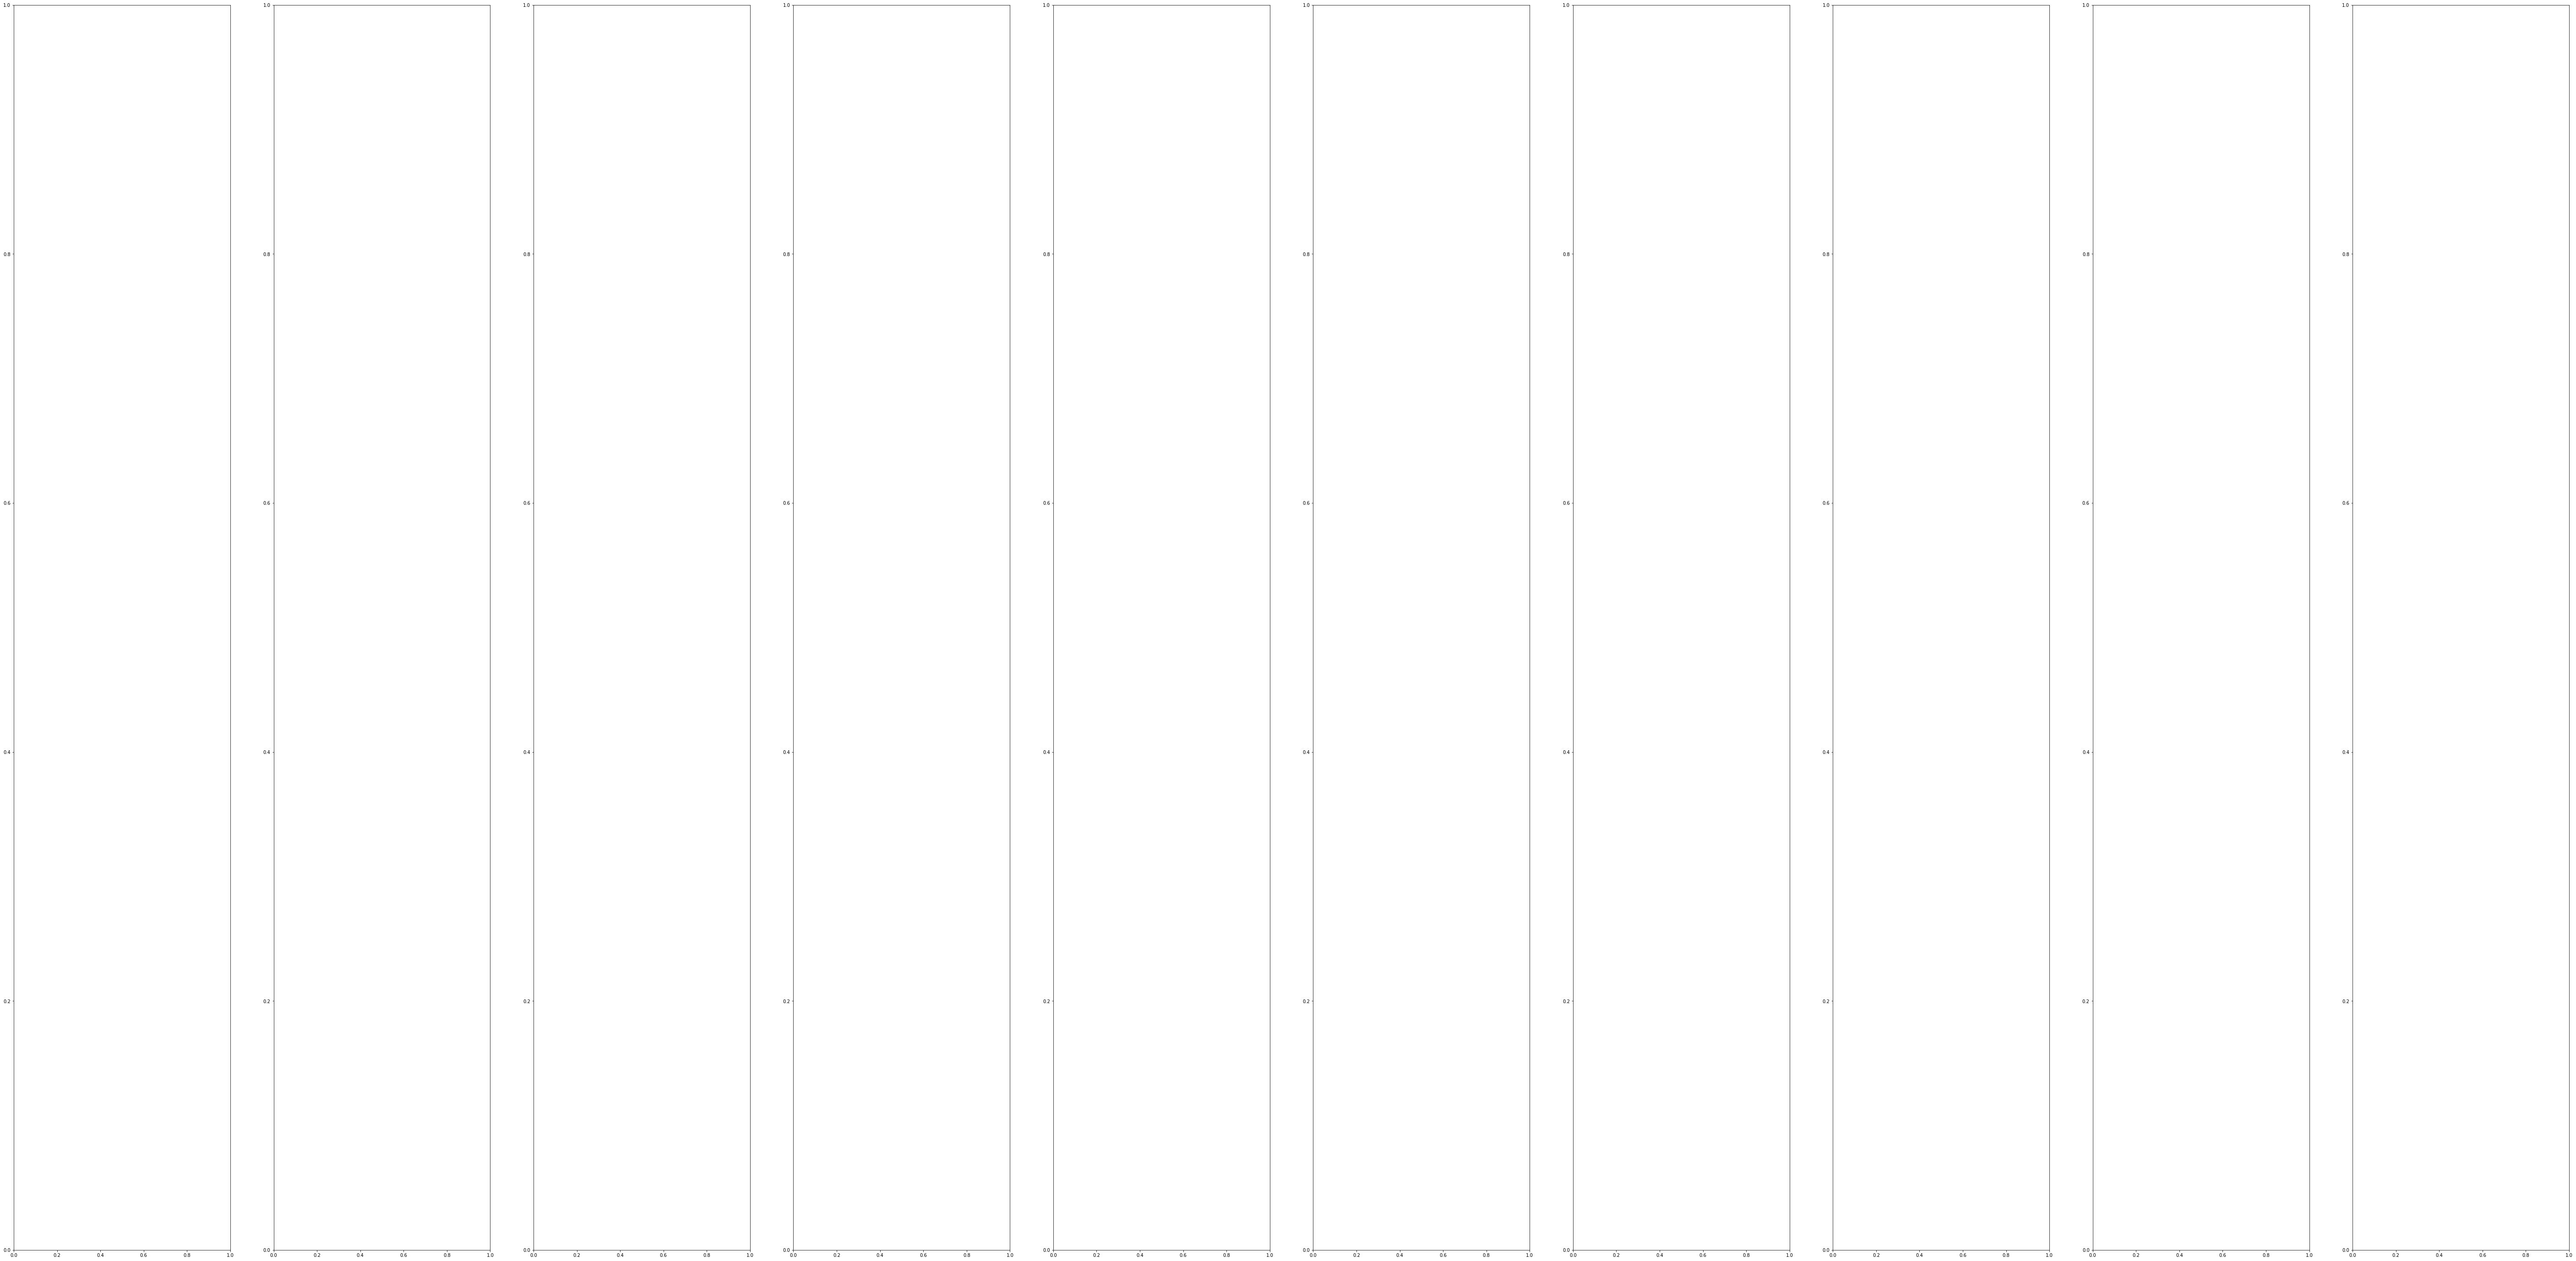

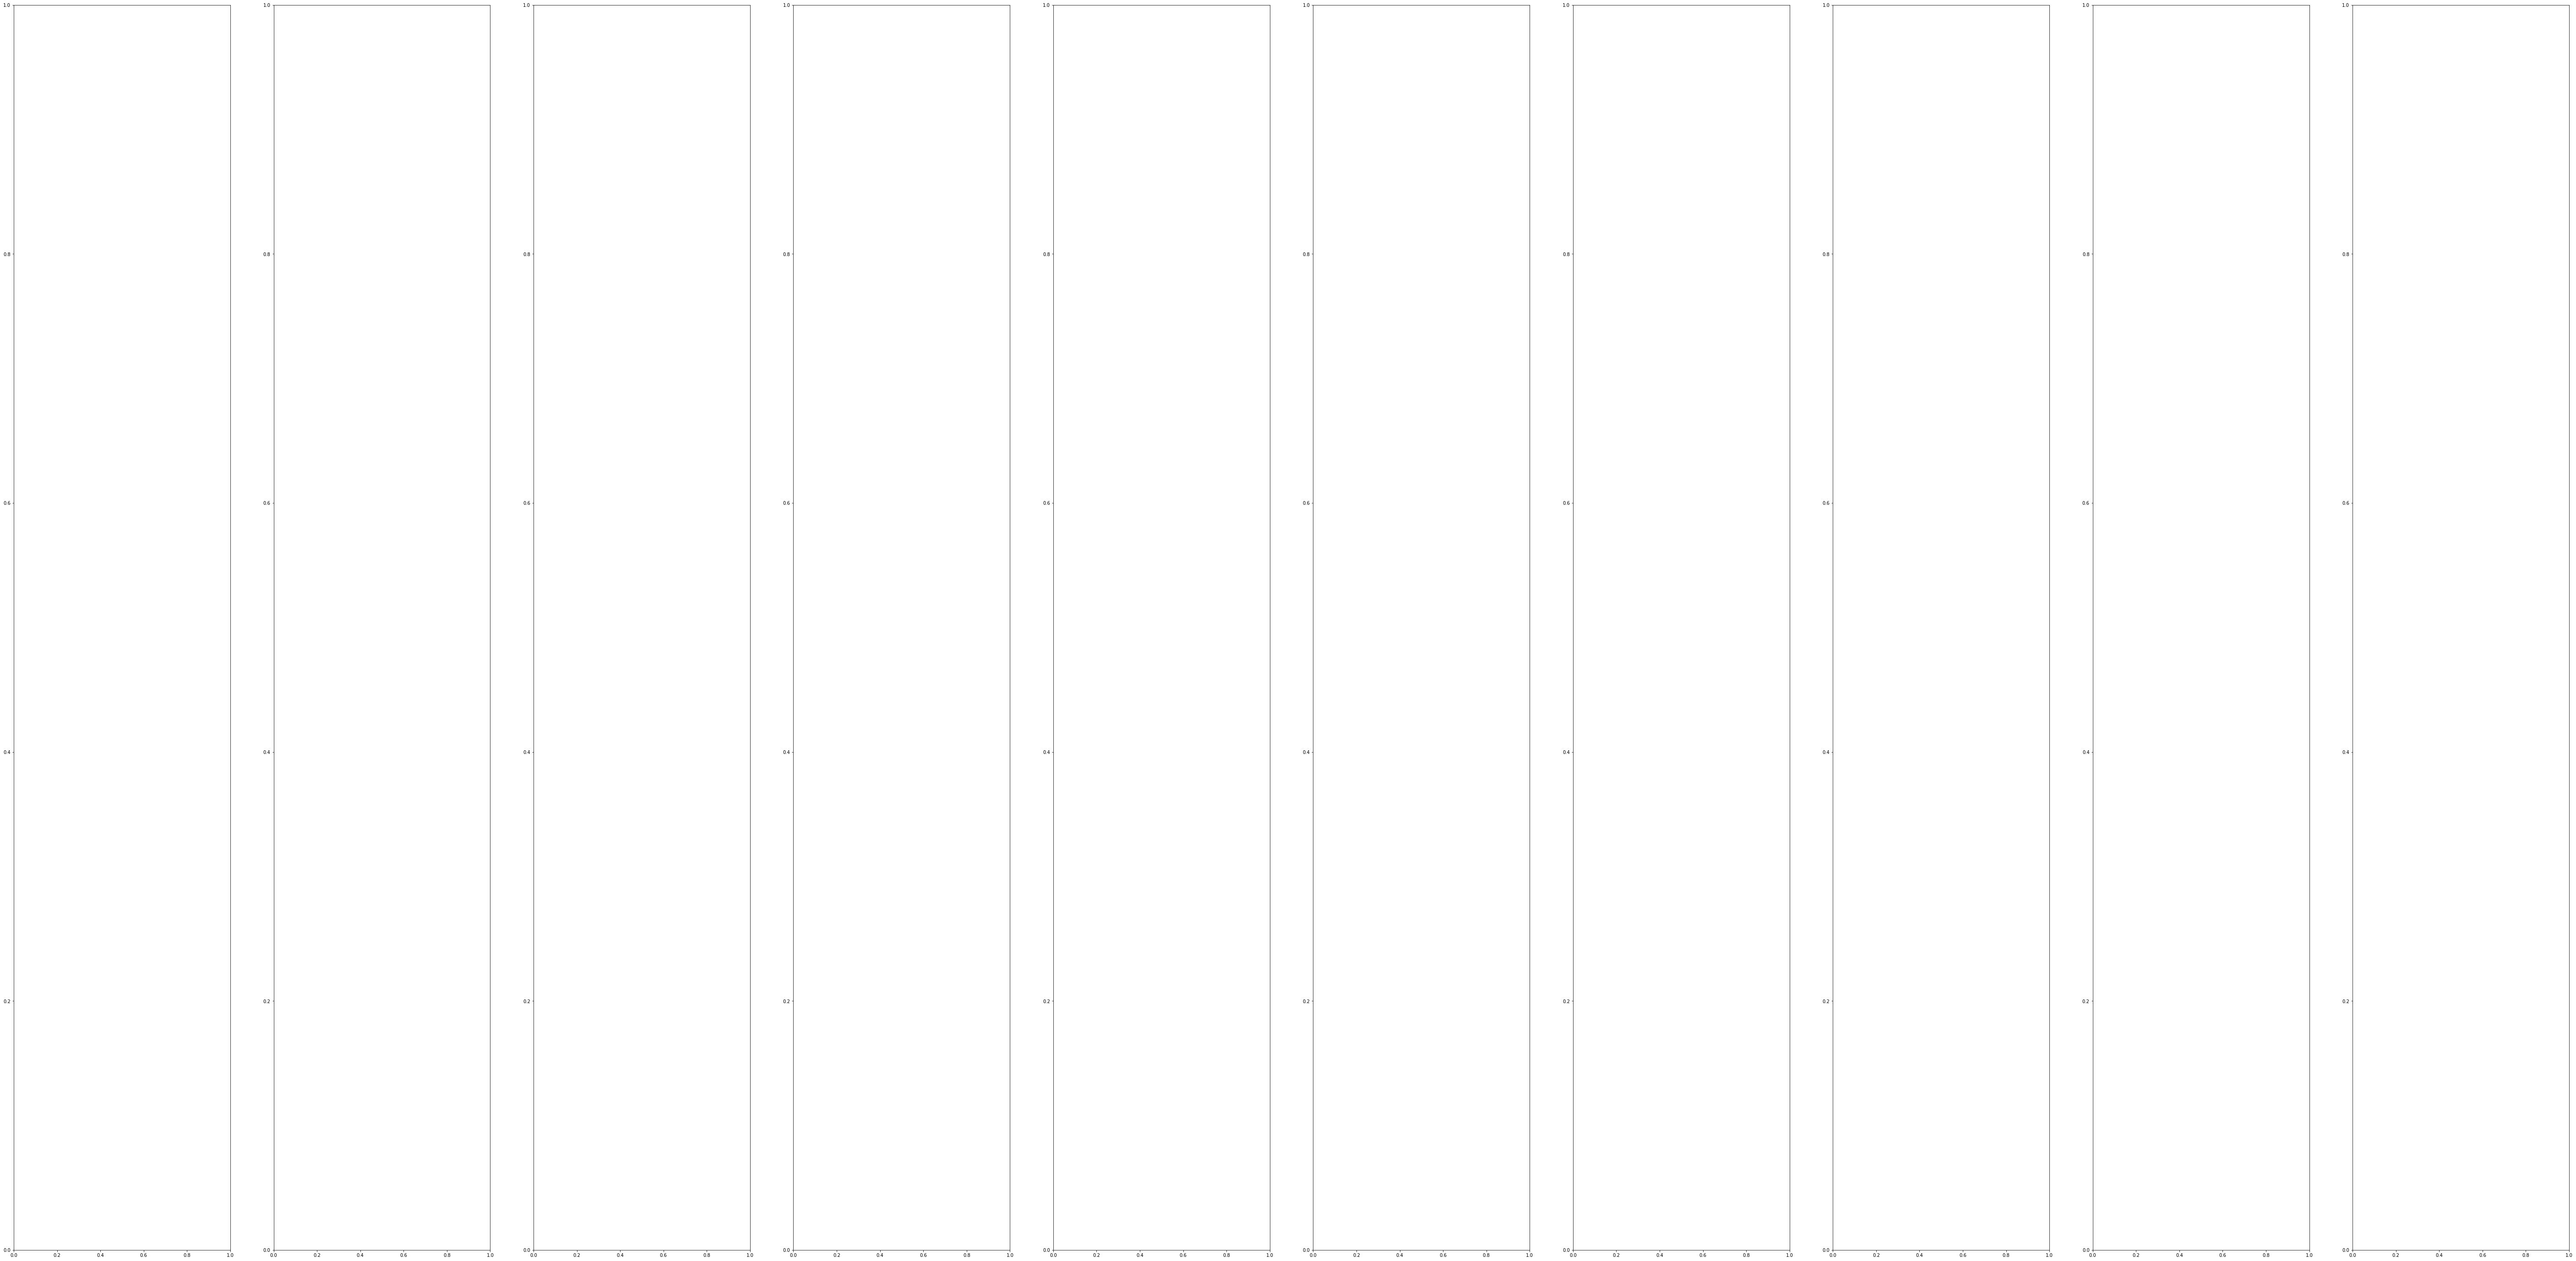

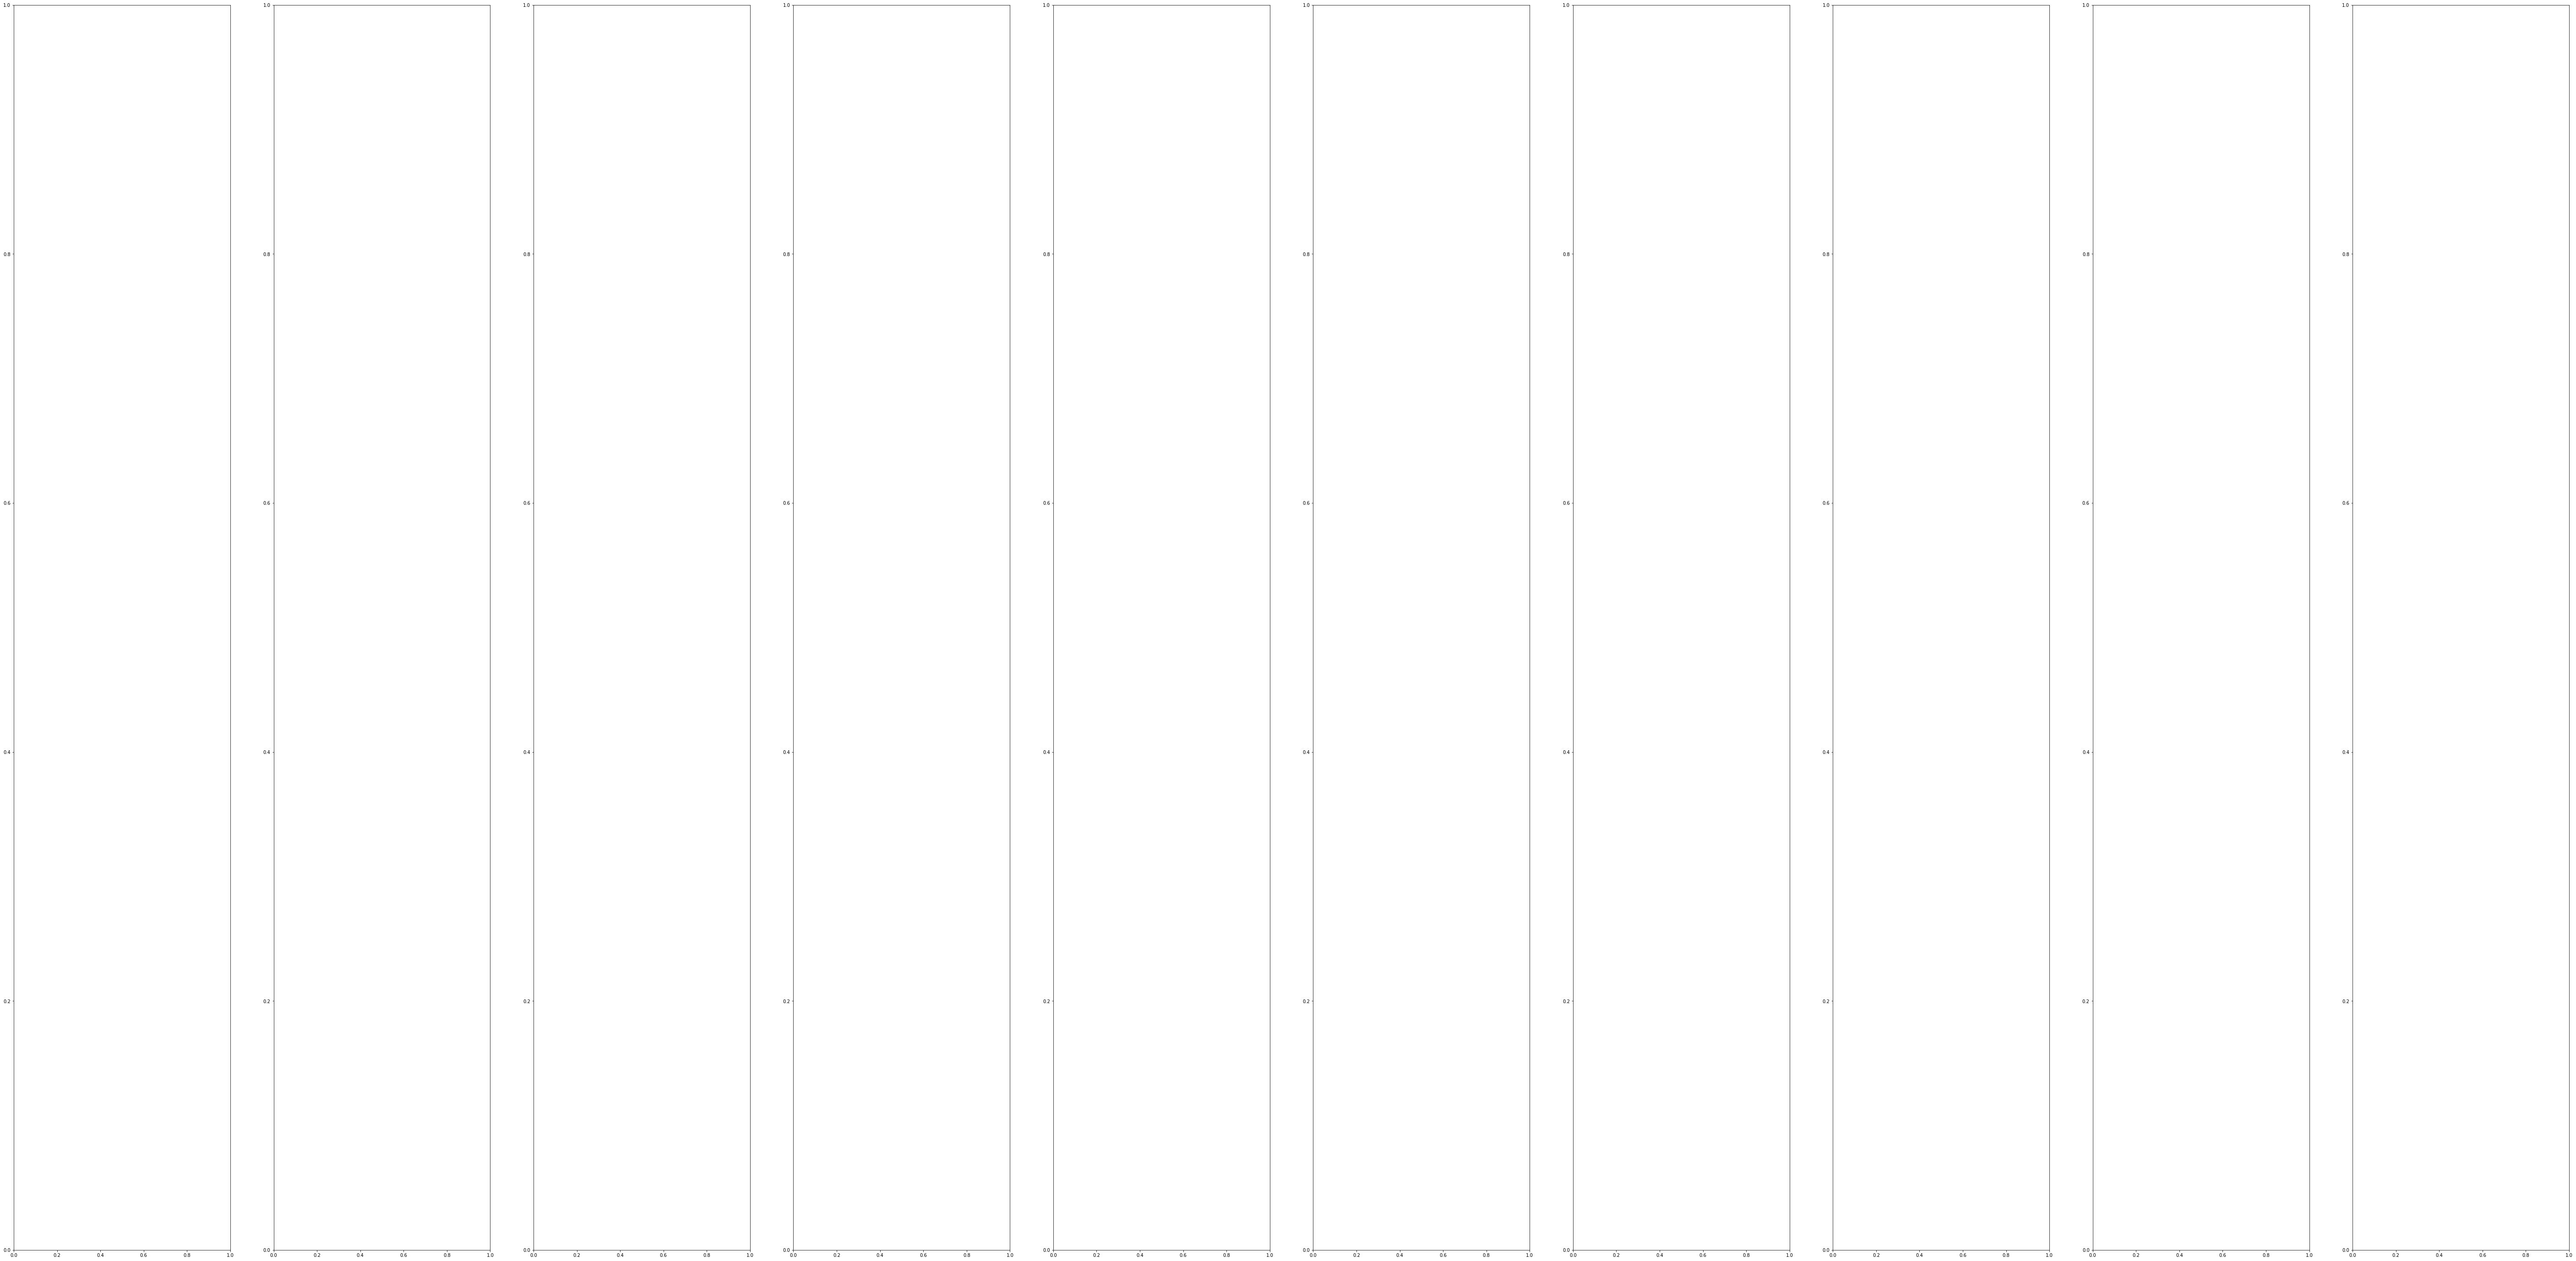

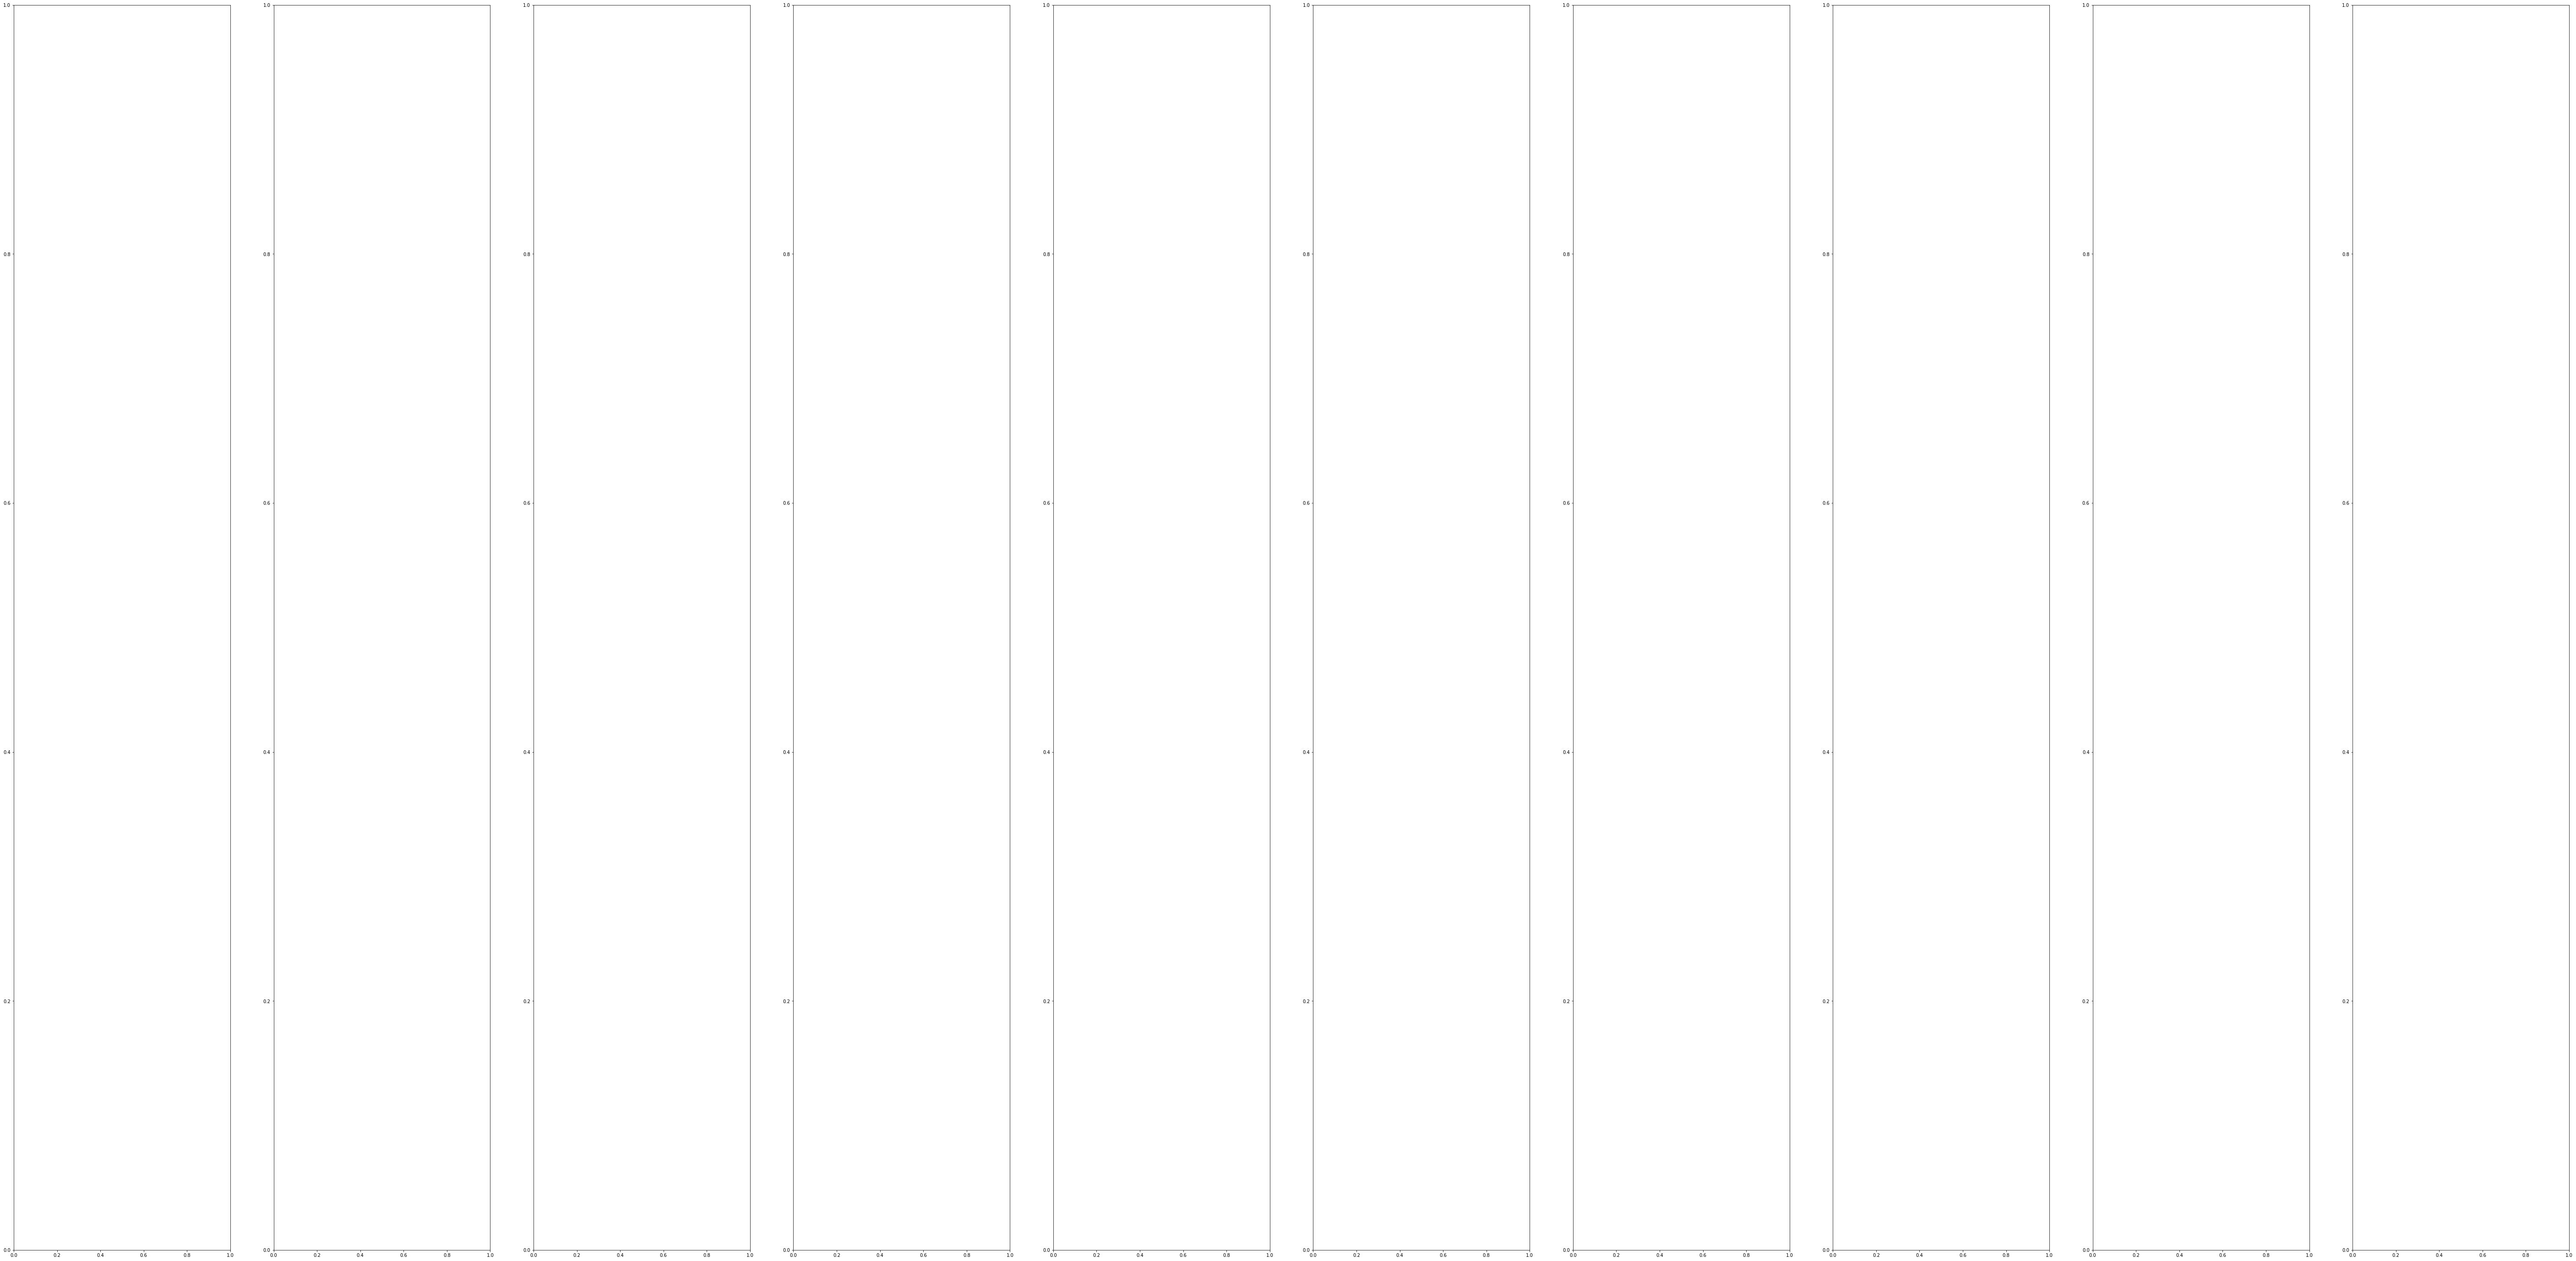

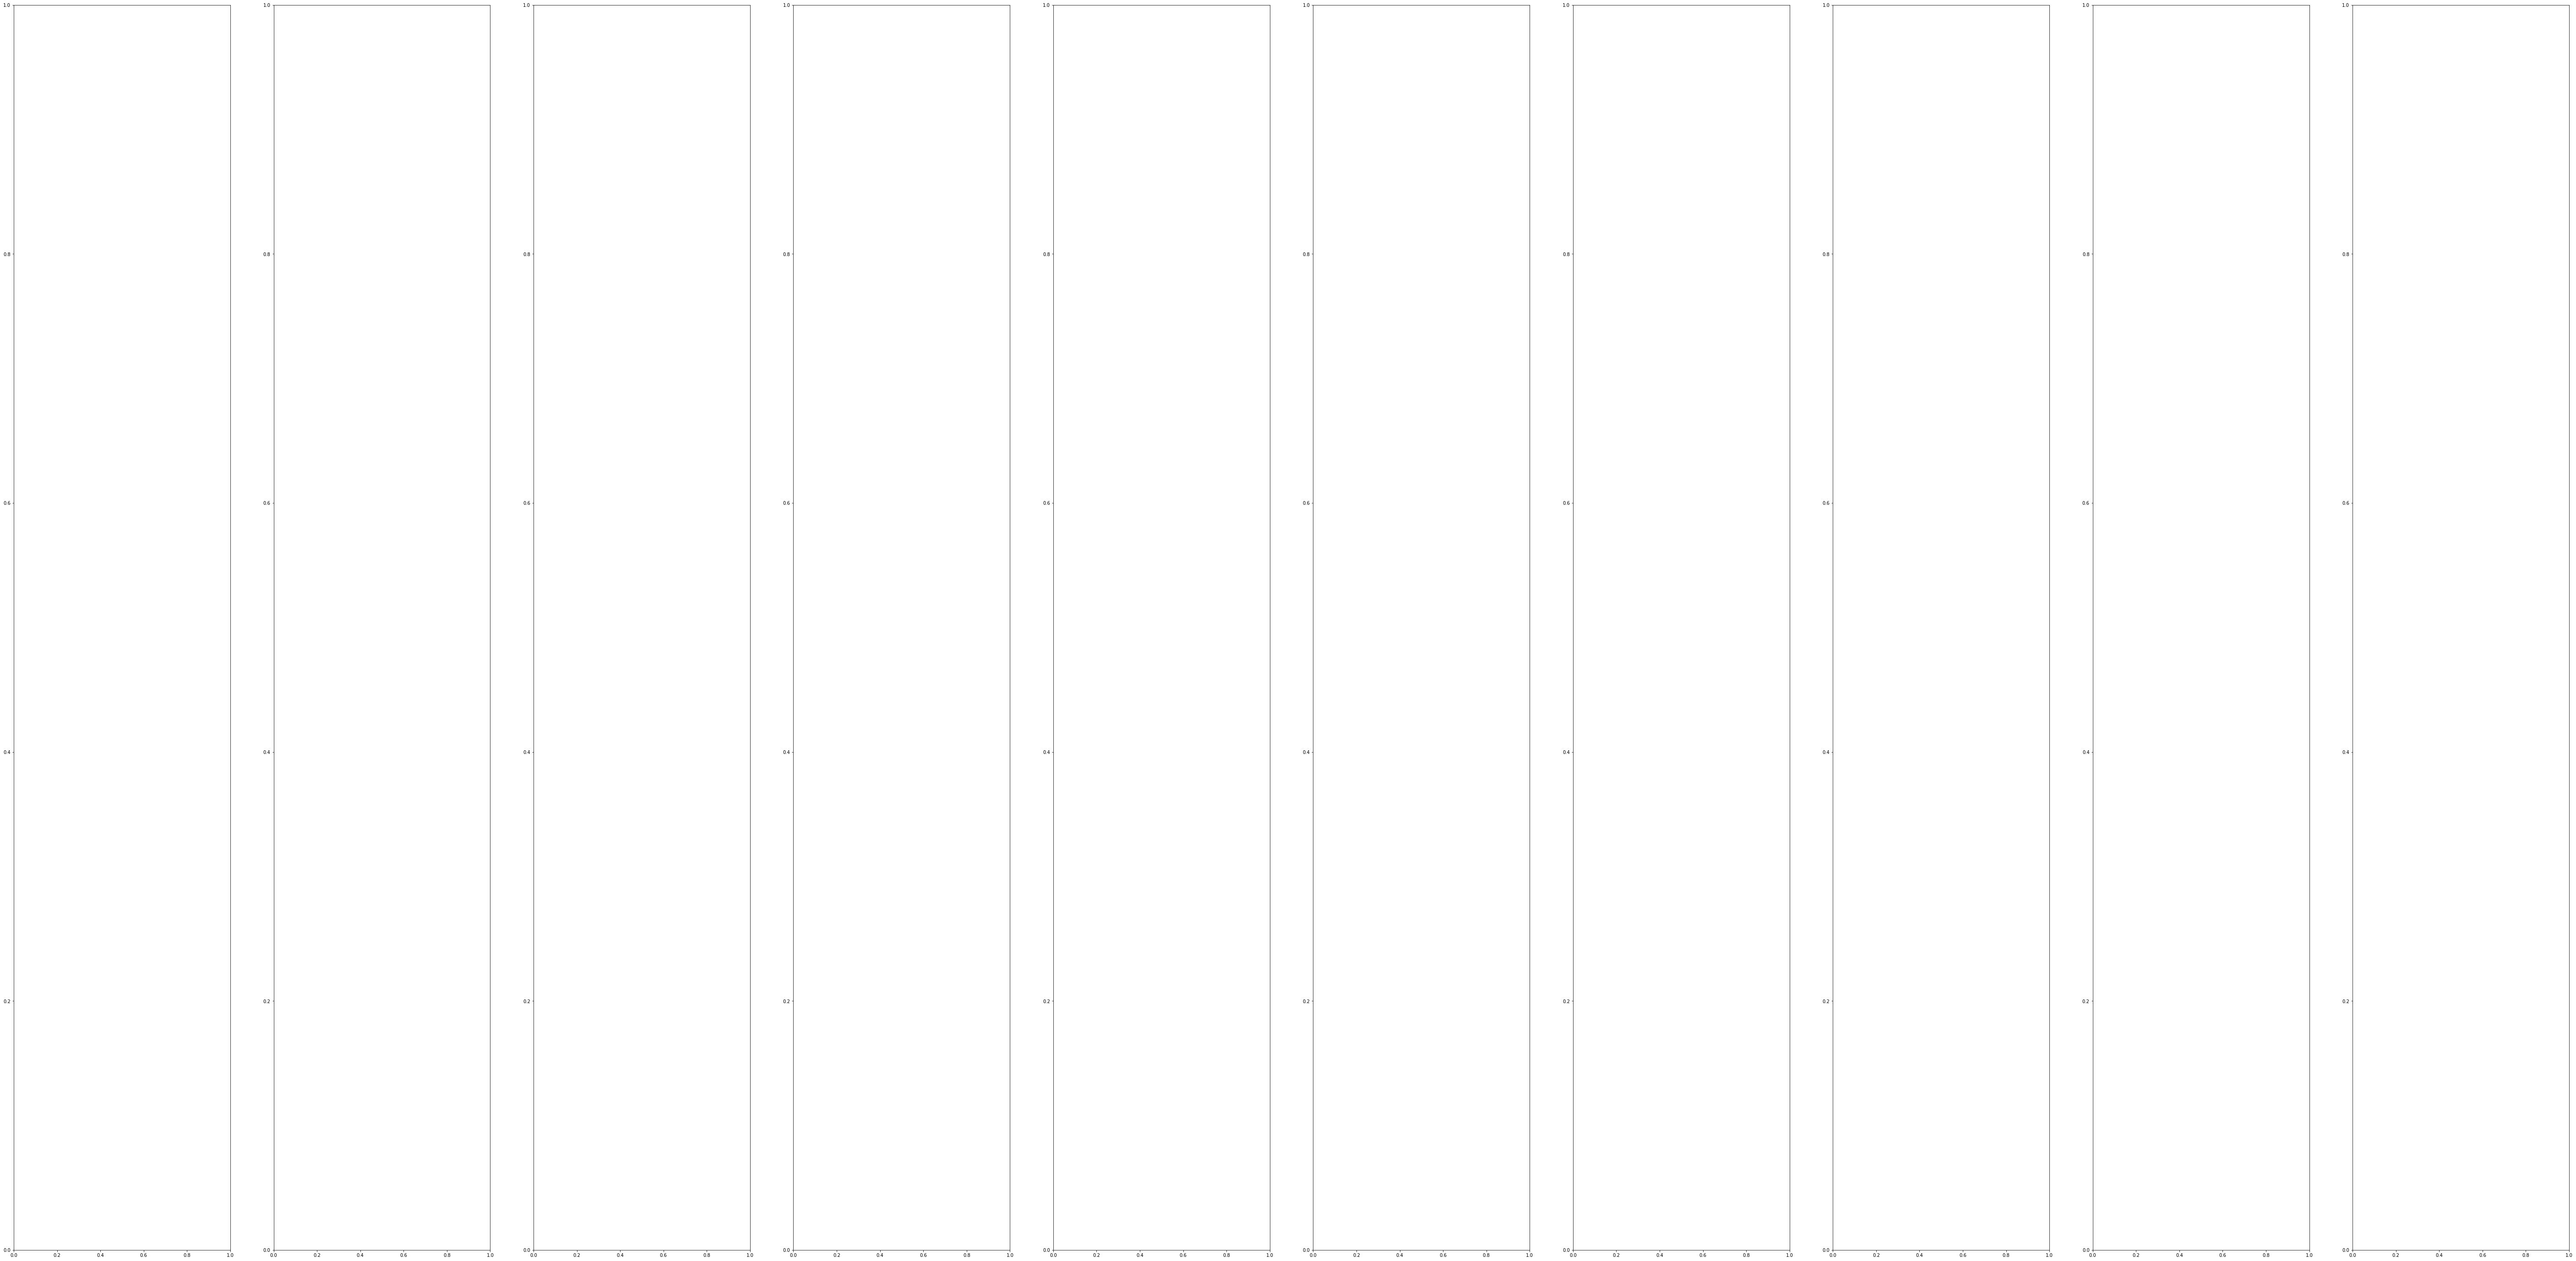

In [46]:
def svd_jacobian_f(f, fname): 
    with tf.GradientTape() as t:
        y_hat = model(x) 
    jac = t.jacobian(y_hat, f)
#     print(jac)
    if jac != None: 
        print(jac.shape)
    
#     fig, ax = plt.subplots(1, 10, figsize=(100,50))

    for i in range(10):
        (jac[0, i])
        print(s[:10])
#         ax[i].imshow(tf.expand_dims(s, -1))

#     plt.save_fig(f'jacobian_{gname}_{fname}_{i}')


for f, fname in [(model.trainable_variables[0], 'fc1'), 
             (model.trainable_variables[2], 'fc2'), 
             (model.trainable_variables[4], 'fc3'),
            (model.trainable_variables[6], 'fc4'),
            (model.trainable_variables[8], 'fc5')
                ]: 

    svd_jacobian_f(f, fname)


In [11]:
print([x.shape for x in model.trainable_variables])




[TensorShape([3, 3, 1, 32]), TensorShape([32]), TensorShape([3, 3, 32, 64]), TensorShape([64]), TensorShape([1600, 10]), TensorShape([10])]


time = 0.19061017036437988
(10, 196, 128)


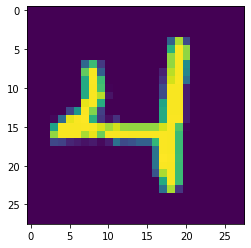

In [47]:
# Derivative wrt model weights

"""
Forward pass on the one image: 6 * 10^5 ops 

Backward pass: 1.2 * 10^6 ops 

~1000 variables we are differentiating wrt... but this is the same as the input 

Oberved: .2 seconds. But this is way faster than forward + backward pass would predict, what's going on? 
"""

l1_weights = model.trainable_variables[0]

i = 103

x = tf.Variable(x_test[i:i+1])
plt.imshow(x[0])
y_true = y_test[i]    
y_hat = tf.Variable(tf.zeros(10))

with tf.GradientTape() as t:
    y_hat = model(x) 
    start = time.time() 
    jac = t.jacobian(y_hat, l1_weights)[0]
    end = time.time() 
    print(f'time = {end - start}')

    print(jac.shape)

#CNN
# rows = 8 
# cols = 4
# fig, ax = plt.subplots(rows, cols, figsize=(100,50))

# for i in range(rows):
#     for j in range(cols): 
#         filter = cols*i + j
#         ax[i, j].imshow(jac[int(y_true), :, :, 0, filter])

In [ ]:
"""
SVD: Guess is 10n^3 for an nxn matrix 

So this is 10(30^3) = 2,700,000 ops = 2.7 * 10^-4 seconds 


Jacobian: This is basically a forward + backward pass through the network. 10 times, because we have 10 outputs. 

forward + backward = 5*10^6 + 1.5*10^7 = 1.5* 10^7 ops 

total = 1.5*10^8 ops. 

"""

num = 10

fig, axes = plt.subplots(nrows=num, ncols=1)

for i in range(num):
    
    x = tf.Variable(x_test[i:i+1])
    plt.imshow(x[0])
    y_true = y_test[i]    
    y_hat = tf.Variable(tf.zeros(10))

    with tf.GradientTape() as t:
        y_hat = model(x) 
        
        st = time.time() 
        grad = t.jacobian(y_hat, x)[0]
        en = time.time()
        print(f'time to compute jacobian = {en - st}')
        
        #     print(y)
#         print(grad.shape)
        grad = grad[0, int(y_true), 0]
#         print(grad.shape)
        st = time.time() 
        s, u, v = tf.linalg.svd(grad, full_matrices=False)
        en = time.time()
        print(f'time to compute svd = {en - st}')
        # s = tf.linalg.diag(s)
        #     print(s)
#         print(tf.reduce_max(s, axis=0))
#         print(tf.reduce_min(s, axis=0))
        
        axes[i].matshow(tf.expand_dims(s, 0));
        axes[i].set_axis_off()


In [ ]:
"""
given a single image, this block prints out the diagonal entries of the jacobians with respect to each output class

"""

image_idx = 1


print(f'y_true = {y_test[image_idx]}') 


x = tf.Variable(x_test[image_idx:image_idx+1])
y_hat = tf.Variable(tf.zeros(10))

plt.matshow(x[0])

fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(500, 50))

with tf.GradientTape() as t:
    y_hat = model(x) 

    grad = t.jacobian(y_hat, {'x': x})['x']
#         print(grad.shape)

for j in range(10):

    grad_j = grad[0, int(j), 0]
#         print(grad.shape)

#     s, u, v = tf.linalg.svd(grad_j, full_matrices=False)
    # s = tf.linalg.diag(s)
    #     print(s)
    #  axes[l].matshow(tf.expand_dims(s, 0), vmin=0, vmax=.25);

    print(tf.reduce_max(grad_j, axis=(0,1)))
    print(tf.reduce_min(grad_j, axis=(0,1)))

    axes[j].matshow(grad_j);

    axes[j].set_axis_off()


In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(500, 50))

print(grad.shape)

for j in range(10):
    grad_j = grad[0, int(j), 0]

    s, u, v = tf.linalg.svd(grad_j, full_matrices=False)

    axes[j].matshow(tf.expand_dims(s, 0));
    axes[j].set_axis_off()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5)

for i in range(2):
    for j in range(5): 
        idx = 5*i + j
        ax[i, j].imshow(x_test[idx])
        ax[i, j].set_axis_off()


In [ ]:
s, u, v = tf.linalg.svd(grad, full_matrices=False)
s = tf.linalg.diag(s)
plt.matshow(x[0])
plt.matshow(u);
plt.matshow(s);
plt.matshow(v);


In [ ]:
#check that the SVD accurately reproduces the gradient
grad_hat = tf.matmul(u, tf.matmul(s, tf.transpose(v)))


plt.matshow(grad)
plt.matshow(grad_hat)

In [ ]:
#experimenting with gradients
x = tf.Variable(3, dtype=tf.float32)

y = tf.Variable([0, 0], dtype=tf.float32)

with tf.GradientTape() as t:
    
    y[0] = x
    
    gradient = t.gradient(y, [x])
    
print(gradient)
    

In [ ]:
 for f, fname in [(model.trainable_variables[0], 'conv1'), 
                 (model.trainable_variables[2], 'conv2'), 
                 (model.trainable_variables[4], 'fc1')]: 
        jacobian_g_f(f, fname, y_hat, 'preds')
             rows = 10
        cols = 1

#         for i in range(10):
#             if 'conv' in fname: 
#                 fig, ax = plt.subplots(rows, cols, figsize=(100,50))
#                 for filter in range(10): 
#                     ax[i].imshow(jac[i, :, :, 0, filter])

#                 plt.save_fig(f'jacobian_{gname}_{fname}_{i}')
#             else:    